In [129]:
import matplotlib.pyplot as plt
# import plumed
# import MDAnalysis
# import torch
import numpy as np
from scipy.stats import multivariate_normal
# import pandas as pd
# import raster_geometry as rg
!pwd


/home/user/Project/Proj23


In [372]:
class DataGen:
    def __init__(self, filename = 'w_metadNa350_short/dump/dump350.lammpstrj', samples_num=2 ,bin_num=20, length=1/3, gauss_len=5):
        self.filename = filename
        self.data = []
        self.bin_num = bin_num
        meta = np.loadtxt(filename, skiprows=5, max_rows=3, usecols=[0,1,2], dtype=float)
        self.length = length*(meta[0,1]-meta[0,0])
        self.middle = []
        for i in range(samples_num):
            meta = np.loadtxt(filename, skiprows=5+(259*i), max_rows=3, usecols=[0,1,2], dtype=float)
            df = np.loadtxt(filename, skiprows=9+(259*i), max_rows=250, usecols=[2,3,4], dtype=float)
            coor = self.augmentDataPoints(df,meta)
#             if i==samples_num-1 :
#                 self.plotPoints(coor)
            middle = self.calculateDiagonal(meta)
#             self.middle.append(middle)
            x,y,z,v = self.createTensor(coor,bin_num,length,middle)
            self.data.append(v)
            
    def calculateDiagonal(self, meta):
        #calculate the diagonal farest point in the parallelpiped 
        xy,xz,yz = meta[0,2], meta[1,2], meta[2,2]
        lx,ly,lz = meta[:,1]-meta[:,0]
        return (lx, np.sqrt(ly**2+xy**2), np.sqrt(lz**2+xz**2+yz**2))
         
    def createTensor(self,coor,n,l,p,var=0.01):
        #create the matrix representing the particles by 3-d Gaussian with mu=0 and var=0.01
        x,y,z= np.meshgrid(np.linspace(p[0]-l/2,p[0]+l/2, n),
                           np.linspace(p[1]-l/2,p[1]+l/2, n),
                           np.linspace(p[2]-l/2,p[2]+l/2, n))
        
        vx =  x[:,:,:,np.newaxis] - coor[np.newaxis,np.newaxis,:,0]
        vy =  y[:,:,:,np.newaxis] - coor[np.newaxis,np.newaxis,:,1]
        vz =  z[:,:,:,np.newaxis] - coor[np.newaxis,np.newaxis,:,2]
        v = np.sum(np.exp(-(vx**2 + vy**2+ vz**2)/var),axis=3)
        return x,y,z,v
    
    def plotTensor(self,v, middle):
        #scatters the 3-D tensor
        n,l,p = self.bin_num, self.length, middle 
        x,y,z= np.meshgrid(np.linspace(p[0]-l/2,p[0]+l/2, n),
                           np.linspace(p[1]-l/2,p[1]+l/2, n),
                           np.linspace(p[2]-l/2,p[2]+l/2, n))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x,y,z, c=v)
        plt.show()
    
    def augmentDataPoints(self,df,meta):
        #recreates the parallelpiped 7 times to get a 2 times factors
        xy,xz,yz = meta[0,2], meta[1,2], meta[2,2]
        lx,ly,lz = meta[:,1]-meta[:,0]

        T = np.array([[lx, xy,xz],[0, ly,yz],[0,0,lz]])
        T_inv = np.linalg.inv(T)
        nc = df.dot(T_inv) ##normalized coordinates
        return np.dot(np.concatenate((nc,nc+(1,0,0),nc+(0,1,0),nc+(1,1,0),
                                        nc+(0,0,1),nc+(1,0,1),nc+(0,1,1),nc+(1,1,1))),1)
    
    def plotPoints(self, points):
        #scatters the 3-D points in space
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:,0],points[:,1],points[:,2])
        ax.view_init(90,0)

        plt.show()
        
        


    
        

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 2.77555756e-17]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


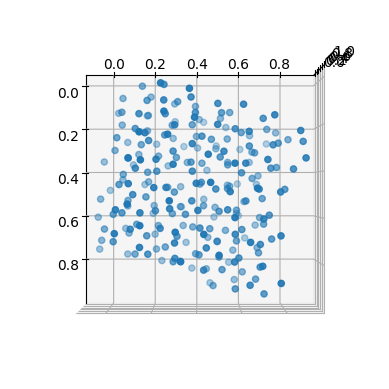

In [407]:
dat = DataGen()


Text(0.5, 0, 'Z')

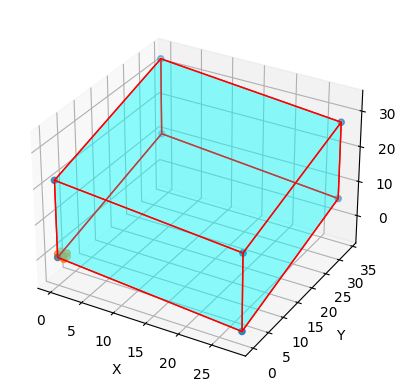

In [490]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt

lox,loy,loz = meta[:,0]
hix,hiy,hiz = meta[:,1]

# points = np.array([[lox, loy, loz],
#                   [hix, loy, loz],
#                   [hix, hiy, loz],
#                   [lox, hiy, loz],  
#                   [lox, loy, hiz],
#                   [hix, loy, hiz],    
#                   [hix, hiy, hiz],
#                   [lox, hiy, hiz]])

# P = [[2.06498904e-01 , -6.30755443e-07 ,  1.07477548e-03],
#  [1.61535574e-06 ,  1.18897198e-01 ,  7.85307721e-06],
#  [7.08353661e-02 ,  4.48415767e-06 ,  2.05395893e-01]]

points = np.array([[0, 0, 0],
                  [1, 0, 0 ],
                  [1, 1, 0],
                  [0, 1, 0],
                  [0, 0, 1],
                  [1, 0, 1 ],
                  [1, 1, 1],
                  [0, 1, 1]])

P=T
Z = np.zeros((8,3))
for i in range(8): Z[i,:] = np.dot(points[i,:],P)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

r = [0,0]

ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

# list of sides' polygons of figure
verts = [[Z[0],Z[1],Z[2],Z[3]],
 [Z[4],Z[5],Z[6],Z[7]], 
 [Z[0],Z[1],Z[5],Z[4]], 
 [Z[2],Z[3],Z[7],Z[6]], 
 [Z[1],Z[2],Z[6],Z[5]],
 [Z[4],Z[7],Z[3],Z[0]]]

# plot sides
ax.add_collection3d(Poly3DCollection(verts, 
 facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))
ax.scatter(points[:,0],points[:,1],points[:,2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

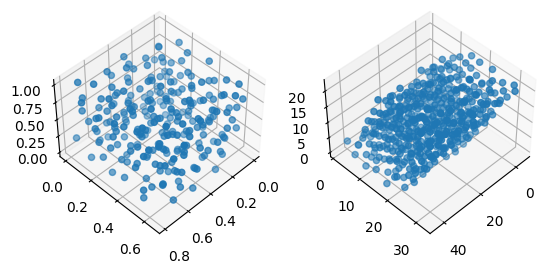

In [507]:
filename = 'w_metadNa350_short/dump/dump350.lammpstrj'
i = 5
meta = np.loadtxt(filename, skiprows=5+(259*i), max_rows=3, usecols=[0,1,2], dtype=float)
df = np.loadtxt(filename, skiprows=9+(259*i), max_rows=250, usecols=[2,3,4], dtype=float)

xy,xz,yz = meta[0,2], meta[1,2], meta[2,2]
lx,ly,lz = meta[:,1]-meta[:,0]
lox,loy,loz = meta[:,0]
hix,hiy,hiz = meta[:,1]

T_inv.dot(np.array([lox,loy,loz]))

T = np.array([[lx, xy,xz],[0, ly,yz],[0,0,lz]])#/(lx*np.sqrt(ly**2-xy**2)*np.sqrt(lz**2-xz**2-yz**2))

T_inv = np.linalg.inv(T)
# nc = np.dot(df,T_inv) ##normalized coordinates
tmp = np.array([hix/lx,loy/ly,loz/lz])
points1=df.dot(T_inv.T)
points2 = np.concatenate((df,df+T.dot(tmp)))
# points = np.concatenate((df.dot(T),(df+tmp).dot(T))) ## for scaled coordinates

# points = np.dot(np.concatenate((nc,nc+(1,0,0),nc+(0,1,0),nc+(1,1,0),nc+(1,0,1),nc+(1,0,1),nc+(0,1,1),nc+(1,1,1))),T)
# c=np.array([[0,1,0],[0,1,0]])
# c.dot(T)
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(points1[:,0],points1[:,1],points1[:,2])
ax.view_init(45,45)

ax = fig.add_subplot(122, projection='3d')
ax.scatter3D(points2[:,0],points2[:,1],points2[:,2])
ax.view_init(45,45)

# T_inv.dot(np.array([hix,hiy,hiz]))



In [ ]:
nc = df.dot(T_inv)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2])
ax.view_init(0,0)

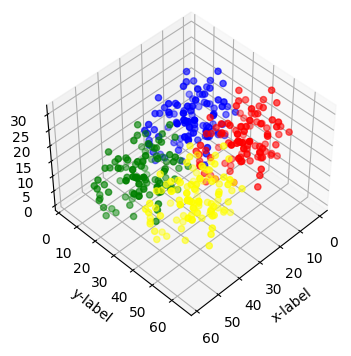

In [455]:

xy,xz,yz = meta[0,2], meta[1,2], meta[2,2]
lx,ly,lz = meta[:,1]-meta[:,0]
T = np.array([[lx, xy,xz],[0, ly,yz],[0,0,lz]])
z=np.random.rand(100,3)
tmp = np.dot(z,T)
tmp2 = z.dot(T)+np.array([0,1,0]).dot(T)
tmp3 = z.dot(T)+np.array([1,0,0]).dot(T)
tmp4 = z.dot(T)+np.array([1,1,0]).dot(T)



# tmp = np.random.rand(10000,3)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(tmp[:,0],tmp[:,1],tmp[:,2],color='blue')
ax.scatter(tmp2[:,0],tmp2[:,1],tmp2[:,2],color='red')
ax.scatter(tmp3[:,0],tmp3[:,1],tmp3[:,2],color='green')
ax.scatter(tmp4[:,0],tmp4[:,1],tmp4[:,2],color='yellow')

plt.xlabel("x-label")
plt.ylabel("y-label")
ax.view_init(45,45)

plt.show()


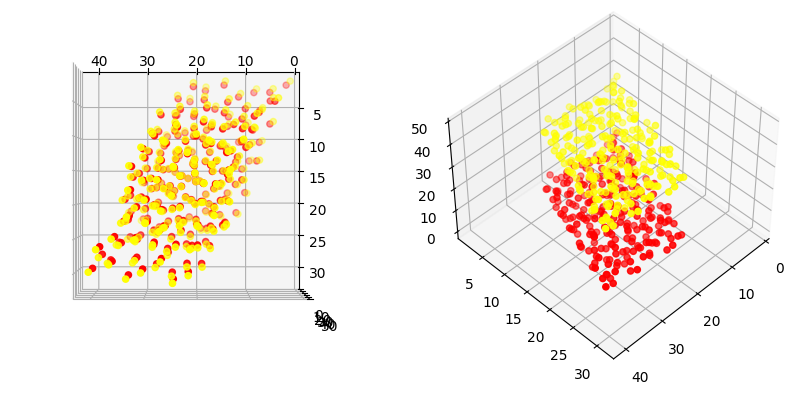

In [157]:

xy,xz,yz = data.meta[0,2], data.meta[1,2], data.meta[2,2]

coor = np.concatenate((df,df+(l[0]-b_cos_alpha,0,0))) #,df+(a.meta[0,2],v[1],0),df+(v[0]+a.meta[0,2],v[1],0))) #,
#                        df+(0,0,v[2]), df+(v[0],0,v[2]),df+(0,v[1],v[2]),df+(v[0],v[1],v[2])))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(121,projection='3d')
ax.scatter(df[:,0],df[:,1],df[:,2], color='red')
ax.scatter(df[:,0],df[:,1],df[:,2]+c, color='yellow')
# ax.scatter(df[:,0]+a_cos_alpha,df[:,1],df[:,2], color='blue')
ax.view_init(90,90)
ax = fig.add_subplot(122,projection='3d')
ax.scatter(df[:,0],df[:,1],df[:,2], color='red')
ax.scatter(df[:,0],df[:,1],df[:,2]+c, color='yellow')
# ax.scatter(df[:,0]+l[0]-a_cos_alpha,df[:,1],df[:,2], color='blue')
ax.view_init(45,45)
plt.show()

In [40]:
data = DataGen(samples_num=5)
df=data.df

21.9274
27.4549
30.3282
28.3362
40.535


In [2]:
class DataGen:
    def __init__(self, filename = '../GpuLab/w_metadNa350_2/dump/pos.xyz', samples_num=1000 ,bin_num=20, gauss_len=5):
        self.filename = filename
        self.data = []
        for i in range(samples_num):
            df = np.loadtxt(filename, skiprows=2+(252*i), max_rows=250, usecols=[1,2,3], dtype=float)
            
            ##add periodic coordinates and normlize to bin num
            df=df.T
            length = np.ceil(df.max()) - np.floor(df.min())
            arr = np.empty((3,250), float)
            for i in range(3):
                for j in range(3):
                    for k in range(3):
                        arr = np.concatenate((arr,np.array((df[0]+(i*length),df[1]+(j*length),df[1]+(k*length)))),axis=1)
            arr=arr.T[250::]
            coor = (arr*bin_num/length).astype(np.int_)
            
            ##create multivariate normal 
            x, y,z = np.mgrid[-1:1:5j, -1:1:5j,-1:1:5j]
            pos = np.stack((x, y,z))
            rv = multivariate_normal([0,0,0], [[1,0,0],[0,1,0],[0,0,1]])
            mvpdf = rv.pdf(pos.T)

            ##create density matrix
            l = gauss_len
            m = np.zeros((3*bin_num,3*bin_num,3*bin_num))     
            lim = np.arange(bin_num-int((l+1/2)),2*bin_num+int((l+1/2)))
            for val in coor:
                if val[0]>lim[0] and val[0]<lim[-1] and val[1]>lim[0] and val[1]<lim[-1] and val[2]>lim[0] and val[2]<lim[-1]:
                    m[val[0]-int(l/2):val[0]+int(l/2)+1, val[1]-int(l/2):val[1]+int(l/2)+1, 
                      val[2]-int(l/2):val[2]+int(l/2)+1] += mvpdf
                    
            self.data.append(m[bin_num:2*bin_num,bin_num:2*bin_num,bin_num:2*bin_num])

    
    def getSample(self, i=0):
        if i==0:
            i = np.random.randint(0,samples_num)
        return self.data[i]

    def plotSample(self, i=0):
        if i==0:
            i = np.random.randint(0,samples_num)
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(m[i,:,0],m[i,:,1],m[i,:,2])
        plt.show()


In [4]:
a = DataGen()


In [5]:
np.asarray(a.data).shape

(1000, 20, 20, 20)

In [54]:
df = np.loadtxt(filename, skiprows=252+2, max_rows=250, usecols=[1,2,3], dtype=float)

In [45]:
df=df.T
length = np.ceil(df.max()) - np.floor(df.min())
arr = np.empty((3,250), float)
for i in range(3):
    for j in range(3):
        for k in range(3):
            arr = np.concatenate((arr,np.array((df[0]+(i*length),df[1]+(j*length),df[1]+(k*length)))),axis=1)
arr=arr.T[250::]


In [67]:
df

array([[ 9.463958, 18.513494,  7.306116],
       [ 8.439468, 10.586257,  2.604276],
       [20.121729, 19.243767, 14.375557],
       [21.287184, 11.978092, 15.282744],
       [ 1.140787, 18.091078,  3.842036],
       [12.994061, 11.116761, 11.151342],
       [13.238959, 18.748913,  3.038737],
       [ 5.803178,  3.109009,  7.964418],
       [16.144886,  4.832609, 17.607452],
       [19.544371,  8.842077, 12.97079 ],
       [17.314394,  5.463905, 10.477738],
       [21.508415, 14.057798, 11.198586],
       [23.428537, 12.668921, 20.506294],
       [21.84481 , 20.009266, 20.252676],
       [ 6.047698, 20.574766,  8.609923],
       [17.829092,  7.268772,  6.805969],
       [14.103289,  1.792337, 15.50979 ],
       [19.008575, 14.019733,  8.31995 ],
       [ 7.2407  ,  5.810244, 17.393524],
       [22.304916, 22.050896, 16.216799],
       [ 6.435778,  9.395305, 16.595465],
       [ 5.040262, 10.342875,  7.556019],
       [19.779251,  5.041419, 13.287675],
       [20.003187, 18.768538,  1.2

In [6]:
##multivariate normal generation
d = 1
r = 5j
x, y,z = np.mgrid[-d:d:r, -d:d:r,-d:d:r]
# x = np.ones((3,3,3))
pos = np.stack((x, y,z))
rv = multivariate_normal([0,0,0], [[1,0,0],[0,1,0],[0,0,1]])
a = rv.pdf(pos.T)
a

array([[[0.01416735, 0.02061337, 0.023358  , 0.02061337, 0.01416735],
        [0.02061337, 0.02999227, 0.03398569, 0.02999227, 0.02061337],
        [0.023358  , 0.03398569, 0.03851084, 0.03398569, 0.023358  ],
        [0.02061337, 0.02999227, 0.03398569, 0.02999227, 0.02061337],
        [0.01416735, 0.02061337, 0.023358  , 0.02061337, 0.01416735]],

       [[0.02061337, 0.02999227, 0.03398569, 0.02999227, 0.02061337],
        [0.02999227, 0.0436385 , 0.04944889, 0.0436385 , 0.02999227],
        [0.03398569, 0.04944889, 0.05603294, 0.04944889, 0.03398569],
        [0.02999227, 0.0436385 , 0.04944889, 0.0436385 , 0.02999227],
        [0.02061337, 0.02999227, 0.03398569, 0.02999227, 0.02061337]],

       [[0.023358  , 0.03398569, 0.03851084, 0.03398569, 0.023358  ],
        [0.03398569, 0.04944889, 0.05603294, 0.04944889, 0.03398569],
        [0.03851084, 0.05603294, 0.06349364, 0.05603294, 0.03851084],
        [0.03398569, 0.04944889, 0.05603294, 0.04944889, 0.03398569],
        [0.02335

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


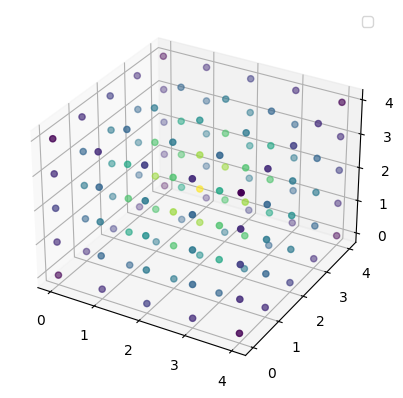

In [46]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
# M = np.random.rand(10, 10, 10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
counter = range(5)
x,y,z = np.meshgrid(counter, counter, counter)
ax.scatter(x,y,z, c=a.flat)
ax.legend()

plt.show()

In [63]:
import raster_geometry as rg
rg.sphere(2*2, 2).astype(np.int_)

array([[[0, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0]],

       [[0, 1, 1, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 1, 1, 0]],

       [[0, 1, 1, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 1, 1, 0]],

       [[0, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0]]])

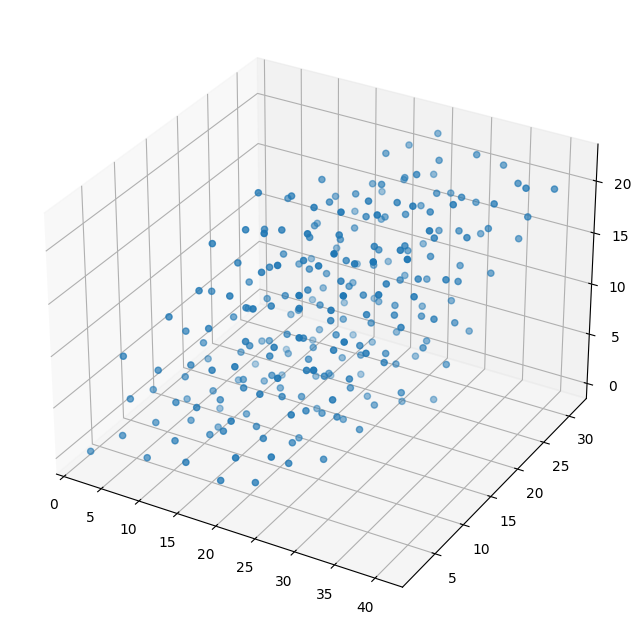

In [117]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(df[:,0],df[:,1],df[:,2])
plt.show()

In [30]:
r = np.random.randn(100,3)
H, edges = np.histogramdd(r, bins = (5, 8, 4))
H.shape, edges[0].size, edges[1].size, edges[2].size


((5, 8, 4), 6, 9, 5)

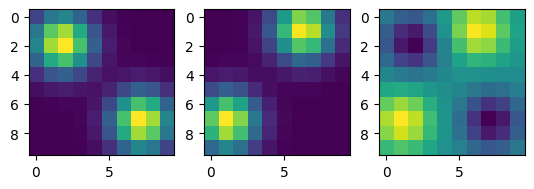

In [20]:
import numpy as np
from matplotlib import pyplot as plt

n = 10
x,y= np.meshgrid(np.linspace(0,1, n), np.linspace(0,1,n))
p1=np.array([[0.2, 0.2], [0.8,0.8]])
p2=np.array([[0.12, 0.8], [0.7,0.1]])
g1 = np.zeros_like(x)
g2 = np.zeros_like(x)
for p in p1:
    g1 += np.exp(-((x-p[0])**2+(y-p[1])**2)/0.05)
for p in p2:
    g2 += np.exp(-((x-p[0])**2+(y-p[1])**2)/0.05)


# c = plt.imshow(g1, vmin = 10000, vmax =100000000,
#                extent =[x.min(), x.max(), y.min(), y.max()],
#                interpolation ='nearest', origin ='lower')
# plt.colorbar(c)
    
fig, axs=plt.subplots(1,3)

axs[0].imshow(g1)
axs[1].imshow(g2)

# axs[1].imshow(g2)
axs[2].imshow(g2-g1)
# %%
# p3 = np.random.randn(123, 3)

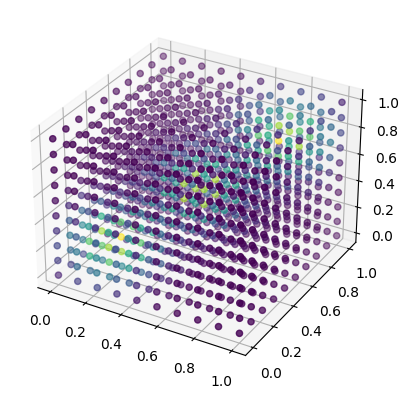

In [49]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

n  = 10
x,y,z= np.meshgrid(np.linspace(0,1, n),np.linspace(0,1, n),np.linspace(0,1,n))
p1=np.array([[0.2, 0.2, 0.2],[0.5,0.5,0.5], [0.8,0.8,0.8]])

vx =  x[:,:,:,np.newaxis] - p1[np.newaxis,np.newaxis,:,0]
vy =  y[:,:,:,np.newaxis] - p1[np.newaxis,np.newaxis,:,1]
vz =  z[:,:,:,np.newaxis] - p1[np.newaxis,np.newaxis,:,2]

v = np.sum(np.exp(-(vx**2 + vy**2+ vz**2)/0.05),axis=3)
# # plt.imshow(v)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, c=v)


plt.show()